In [ ]:
#installs laspy package, needed to analyze .las files
!pip install laspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 615 kB 7.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for laspy: filename=laspy-2.2.0-py3-none-any.whl size=63856 sha256=e9b24fa22051dc29be4fdaa8e44404f50a2e6d9770200c9f3cbeb8c09abec995
  Stored in directory: /root/.cache/pip/wheels/19/6e/01/0dfe379f345dfcfd77907d182cc2b6bae804b52eba66c028f6
Successfully built laspy


In [ ]:
#install needed packages
import numpy as np #does math
import laspy as lp #works with .las files
import matplotlib.pyplot as plt #plots things
from scipy.interpolate import griddata #interpolation method
from scipy import ndimage, misc #max finder
import csv #works with .csv files

#lets us read and write files from google drive
#you will be prompted with a popup window to connect to drive
from google.colab import drive
drive.mount('/content/gdrive')
print('done')

Mounted at /content/gdrive
done


In [ ]:
#Getting the data we want from the .las file into a numpy array

#setting filepath
file_data_path= "gdrive/My Drive/C08rotate.las"
point_cloud=lp.read(file_data_path)

#checking what data the pointcloud stores
#for dimension in point_cloud.point_format.dimensions:
    #print(dimension.name)

#lets me see what the z values are
#zed = np.vstack(point_cloud.z).transpose()
#print(zed) 

#extracting the xyz coordinates of each point into 1 numpy array
xyz = np.vstack((point_cloud.x, point_cloud.y, point_cloud.z)).transpose()

#extracting the rgb colors from each point into 1 numpy array
#note to self, metashape saves color as 16 bit so its 0-65536 instead of 0-255
#rgb = np.vstack((point_cloud.red, point_cloud.green, point_cloud.blue)).transpose()

Xsize:  (1903, 1903)
Ysize:  (1903, 1903)
Zsize:  (1903, 1903)


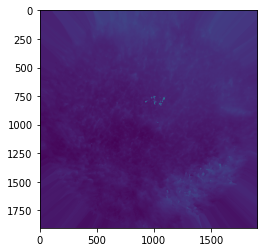

In [ ]:
#interpolation > converting the data from a set of randomly spaced points into a continuous dataset 

#finding the length of our dataset
a,b = xyz.shape
size = int(np.sqrt(a))
#print(size)

#creating a grid based on the size of our dataset 
x = np.linspace(min(xyz[:,0]), max(xyz[:,0]), size)
y = np.linspace(min(xyz[:,1]), max(xyz[:,1]), size)
X,Y = np.meshgrid(x, y)

#interpolating the Z values
Z = griddata((xyz[:,0], xyz[:,1]), xyz[:,2], (X,Y), method='nearest')

#turning the new XYZ data into a list 
XYZ = np.column_stack((X,Y,Z))

#calculatng the size of our dataset, making sure everything lines up
Xsize = np.shape(X)
Ysize = np.shape(Y)
Zsize = np.shape(Z)
print("Xsize: ", Xsize)
print("Ysize: ", Ysize)
print("Zsize: ", Zsize)

#plotting the interpolated data 
plt.imshow(Z)
plt.show()

[[-15.899 -15.899 -15.899 ... -14.955 -14.955 -14.955]
 [-15.899 -15.899 -15.899 ... -14.955 -14.955 -14.955]
 [-15.899 -15.899 -15.899 ... -14.955 -14.955 -14.955]
 ...
 [-16.415 -16.415 -16.415 ... -16.213 -16.213 -16.213]
 [-16.415 -16.415 -16.415 ... -16.213 -16.213 -16.213]
 [-16.415 -16.415 -16.415 ... -16.213 -16.213 -16.213]]
regmax size:  (1903, 1903)
rad:  951.5


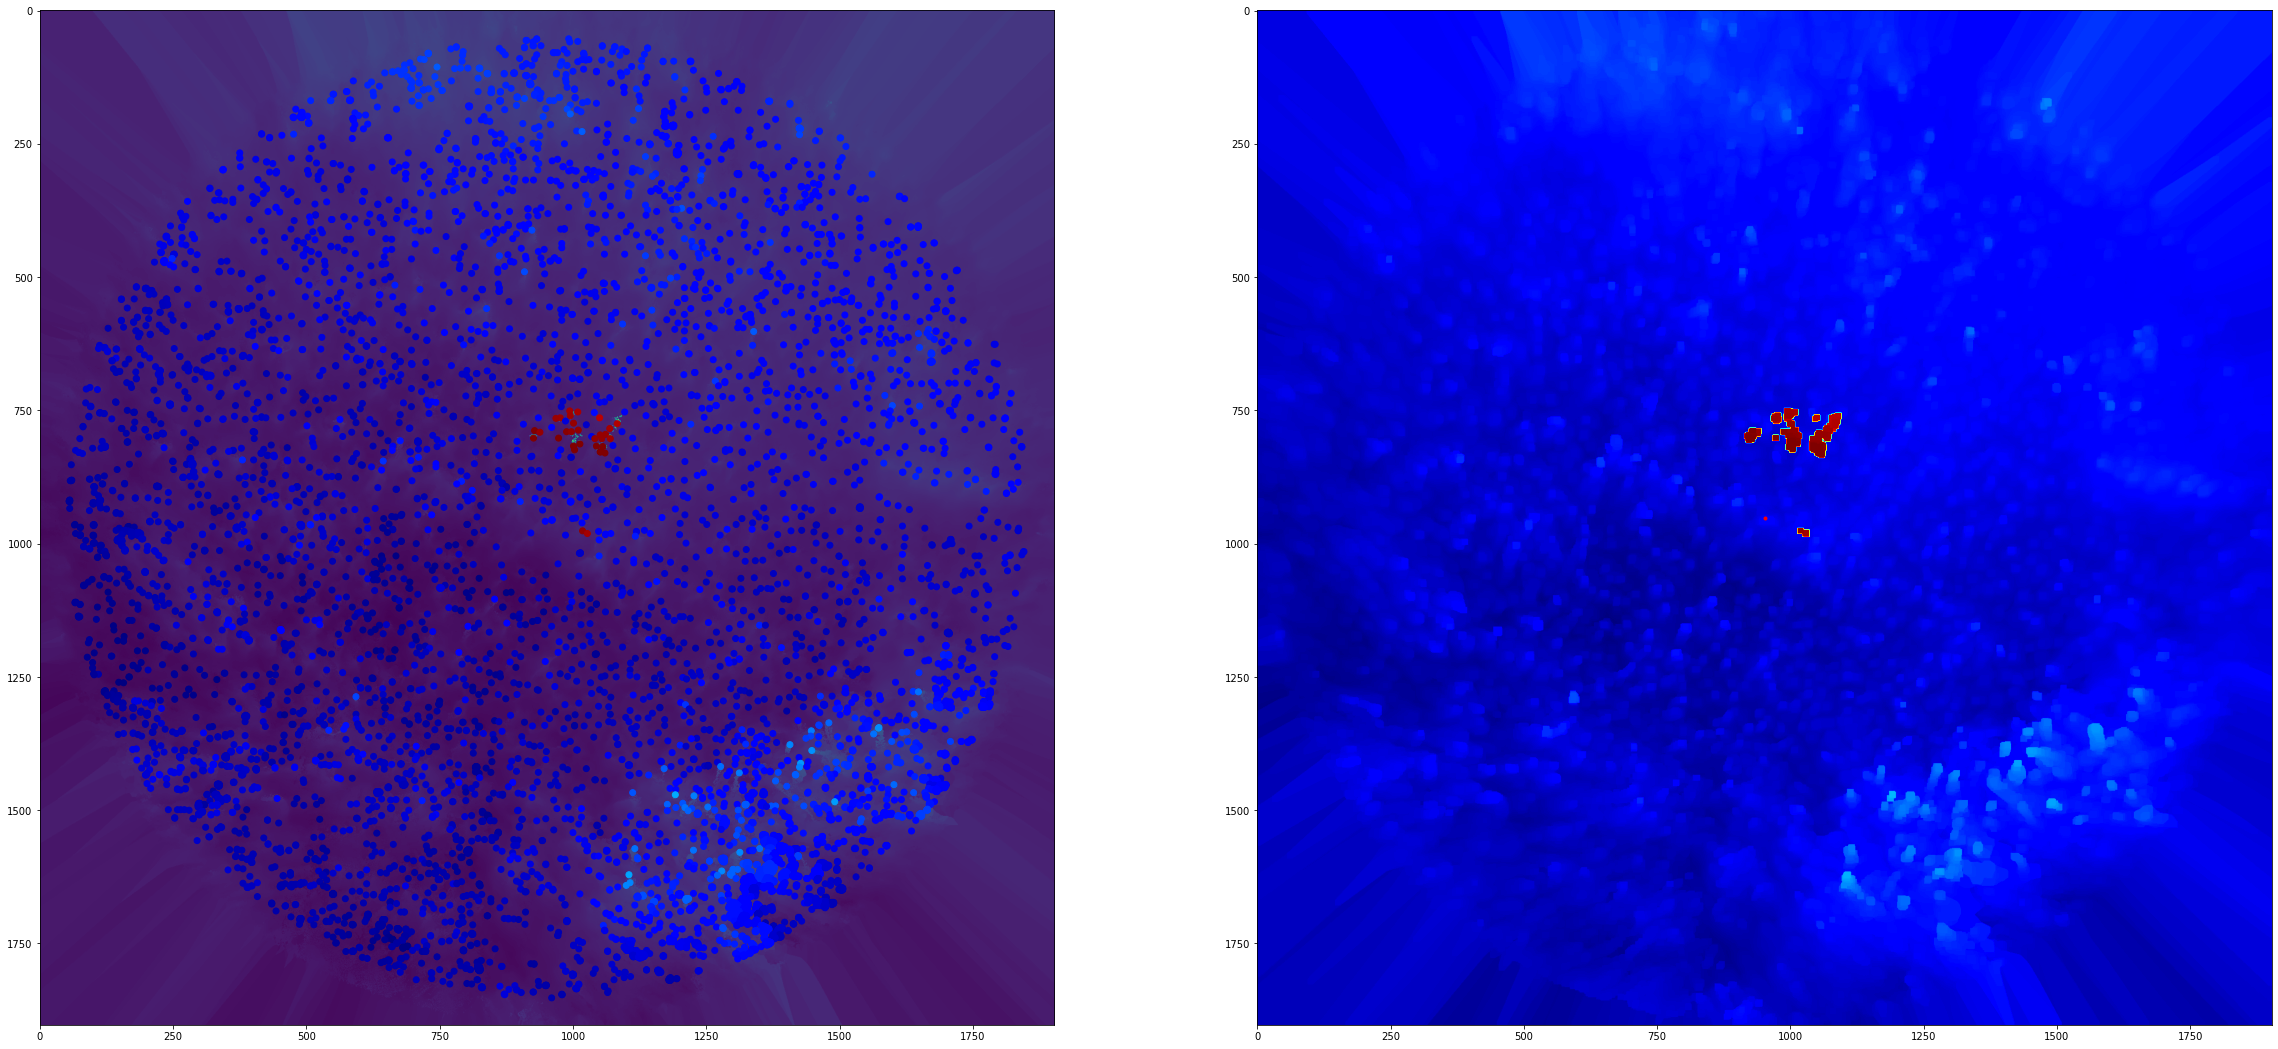

In [ ]:
#finding the local maxima

#finds the local maxima of the image
regmax = ndimage.maximum_filter(Z, size = 8)
#finding which points in the original data are equal to our max-filtered data by finding where the Z values match 
regmaxcoords = ndimage.maximum_filter(Z, size = 8) == Z

#finding the size of the list of maxima coords
#print(regmax)
regmaxsize = np.shape(regmax)
print("regmax size: ", regmaxsize)

#finding the X and Y values of the max Z values
j, i = np.where(regmaxcoords)
coords = np.column_stack((i,j))
#print(coords)
coordssize = np.shape(coords)
#print("coords size: ", coordssize)

#masking the coordinates to only include whatever is inside the circle of valid points
#the radius helps us find the center of the circle
radius = size/2
print("rad: ", radius)
#to get the points within the circle, we use the equation (x-h)^2 + (y-k)^2 = r^2 (circle equation)
#any set of x,y coordinates smaller than r^2 will be inside the circle we want to keep, and we will mask everything outside of that  
mask = (coords[:,0]-(radius))**2 + (coords[:,1]-(radius))**2 < (radius-50)**2 #I use radius - 50 just to be safe and ensure we're excluding junk data
cleanedcoords = coords[mask,:]
cleanedcoordssize = np.shape(cleanedcoords)
#print("cleanedcoords size: ", cleanedcoordssize)

# puts our now filtered coordinates into an array  
cleanedZ = np.array([])
for i,j in cleanedcoords:
  cleanedZ = np.append(cleanedZ,Z[j,i])
#print(cleanedZ)
cleanedZ = np.vstack(cleanedZ)
#cleanedZsize = np.shape(cleanedZ)
#print("cleanedZ size: ", cleanedZsize)

# puts our cleaned XYZ coordinates all into one neat tidy array
cleanedXYZ = np.hstack((cleanedcoords, cleanedZ))
cleanedXYZsize = np.shape(cleanedXYZ)
#print("cleanedXYZ size: ", cleanedXYZ)
#print(cleanedXYZ)

#plotting the figures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (40,40))
#ax 1 (left) plots the original data and the pinnacle peaks onto it 
ax1.imshow(Z)
ax1.scatter(cleanedXYZ[:,0], cleanedXYZ[:,1], c = (cleanedXYZ[:,2]*100000),cmap='jet')
#ax 2 plots the max-filtered image 
ax2.imshow(regmax, cmap = 'jet')
ax2.plot(radius, radius, 'r.')
plt.show()

In [ ]:
#convert cleanedcoords (local maxima x,y,z values)

#change sitename to a file location that makes sense for you.
#name should coordinate with original model name the data is derived from
#include .csv so the file saves as the correct type
sitename = "gdrive/My Drive/C08lessdense.csv"

#creates CSV containing your pinnacle peaks
np.savetxt(sitename, cleanedXYZ, delimiter=",")

<function savetxt at 0x7f4c837138c0>
